##GROUP 5 - ARTIFICIAL INTELLIGENCE

##CognitiveCare: Early Intervention for Alzheimer's Disease

##TEAM ID: NM2023TMID12851


###COLLEGE: SARANATHAN COLLEGE OF ENGINEERING

##Downloading the datasets

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 97% 33.0M/34.1M [00:00<00:00, 37.2MB/s]
100% 34.1M/34.1M [00:00<00:00, 37.3MB/s]


In [ ]:
!unzip /content/alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

##creating training and testing dataset

In [ ]:
trainPath=r"/content/Alzheimer_s Dataset/train"

In [ ]:
testPath=r"/content/Alzheimer_s Dataset/test"

##importing the libraries

In [ ]:
!pip install matplotlib-venn

In [ ]:
from tensorflow.keras.layers import Dense,Flatten,Input

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [ ]:
from tensorflow.keras.applications.xception import Xception,preprocess_input

In [ ]:
from glob import glob

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

##configuring the image datagenerator class

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG


In [ ]:
IMG_SIZE=180
IMAGE_SIZE=[180,180]
DIM=(IMG_SIZE,IMG_SIZE)
ZOOM=[.99,1.01]
BRIGHT_RANGE=[0.8,1.2]
HORZ_FLIP=True
FILL_MODE="constant"
DATA_FORMAT="channels_last"
WORK_DIR="/content/Alzheimer_s Dataset/train"
work_dr=IDG(rescale=1./255,brightness_range=BRIGHT_RANGE,zoom_range=ZOOM,data_format=DATA_FORMAT,fill_mode=FILL_MODE,
            horizontal_flip=HORZ_FLIP)
train_data_gen=work_dr.flow_from_directory(directory=WORK_DIR,target_size=DIM,batch_size=6500,shuffle=False)


Found 5121 images belonging to 4 classes.


In [ ]:
IMG_SIZE=180
IMAGE_SIZE=[180,180]
DIM=(IMG_SIZE,IMG_SIZE)
ZOOM=[.99,1.01]
BRIGHT_RANGE=[0.8,1.2]
HORZ_FLIP=True
FILL_MODE="constant"
DATA_FORMAT="channels_last"
WORK_DIR="/content/Alzheimer_s Dataset/test"
work_dr=IDG(rescale=1./255,brightness_range=BRIGHT_RANGE,zoom_range=ZOOM,data_format=DATA_FORMAT,fill_mode=FILL_MODE,
            horizontal_flip=HORZ_FLIP)
test_data_gen=work_dr.flow_from_directory(directory=WORK_DIR,target_size=DIM,batch_size=6500,shuffle=False)


Found 1279 images belonging to 4 classes.


##handling imbalanced data

In [ ]:
train_data,train_labels=train_data_gen.next()

In [ ]:
print(train_data.shape,train_labels.shape)

(5121, 180, 180, 3) (5121, 4)


In [ ]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)

In [ ]:
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,IMG_SIZE * IMG_SIZE *3),train_labels)

In [ ]:
train_data=train_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [ ]:
print(train_data.shape,train_labels.shape)



(10240, 180, 180, 3) (10240, 4)


##splitting into train and test set

In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)


##pre trained model as cnn feature extractor

In [ ]:
IMAGE_SIZE=[180,180]

In [ ]:
xcep_model=Xception(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
for layer in xcep_model.layers:
  layer.trainable=False

##create sequential layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,GlobalAveragePooling2D,Dropout
custom_inception_model=Sequential([
    xcep_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64,activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4,activation='softmax')
],name="inception_cnn_model")

##configuring the learning process

In [ ]:
import tensorflow
METRICS=[tensorflow.keras.metrics.CategoricalAccuracy(name='acc'),
        tensorflow.keras.metrics.AUC(name='auc') ]
custom_inception_model.compile(optimizer='rmsprop',loss=tensorflow.losses.
                               CategoricalCrossentropy(),metrics=METRICS)

##training the model

In [ ]:
history=custom_inception_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),epochs=1)

205/205 [==============================] - 39s 133ms/step - loss: 1.3212 - acc: 0.4409 - auc: 0.7126 - val_loss: 0.8467 - val_acc: 0.6333 - val_auc: 0.8783


##save the model

In [ ]:
custom_inception_model.save('adp.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##testing the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
import numpy as np

In [ ]:
model=load_model('/content/adp.h5')

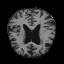

In [ ]:
img = image.load_img('/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (46).jpg',target_size =(64,64))
img

In [ ]:
img=image.load_img(r'/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (46).jpg',target_size=(180,180))
x=image.img_to_array(img)
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
output=np.argmax(model.predict(img_data),axis=1)
output

1/1 [==============================] - 0s 24ms/step


array([0])

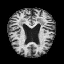

In [ ]:
img = image.load_img('/content/Alzheimer_s Dataset/test/NonDemented/26 (74).jpg',target_size =(64,64))
img

In [ ]:
img=image.load_img(r'/content/Alzheimer_s Dataset/test/NonDemented/26 (74).jpg',target_size=(180,180))
x=image.img_to_array(img)
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
output=np.argmax(model.predict(img_data),axis=1)
output

1/1 [==============================] - 0s 23ms/step


array([0])

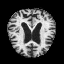

In [ ]:
img = image.load_img('/content/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg',target_size =(64,64))
img

In [ ]:
img=image.load_img(r'/content/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg',target_size=(180,180))
x=image.img_to_array(img)
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape
model.predict(img_data)
output=np.argmax(model.predict(img_data),axis=1)
output

1/1 [==============================] - 0s 26ms/step


array([1])

In [ ]:
model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

##DEPLOYMENT PHASE

In [ ]:
model.save('ibm_adp.h5')

!tar -zcvf ibm_alzheimer-classification.tgz ibm_adp.h5

ibm_adp.h5


In [ ]:
!pip install watson-machine-learning-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install ibm_watson_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"iUsUI8DrxvpHBbiW3lvgfPaHFeTBRJBSDqcaRm2N4SAW"
}

In [ ]:
client = APIClient(wml_credentials)

In [ ]:
client

In [ ]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
169ed087-12ba-4358-a1f1-785d660fb813  Alzheimer_disease  2023-05-20T08:56:09.935Z
------------------------------------  -----------------  ------------------------


,ID,NAME,CREATED
0,169ed087-12ba-4358-a1f1-785d660fb813,Alzheimer_disease,2023-05-20T08:56:09.935Z


In [ ]:
space_uid = "169ed087-12ba-4358-a1f1-785d660fb813"
space_uid

'169ed087-12ba-4358-a1f1-785d660fb813'

In [ ]:
client.set.default_space(space_uid)

'SUCCESS'

In [ ]:
client.software_specifications.list()

----------------------------  ------------------------------------  ----  ------------------  --------------------------
NAME                          ID                                    TYPE  STATE               REPLACEMENT
default_py3.6                 0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base  unsupported         runtime-22.2-py3.10
autoai-ts_rt23.1-py3.10       01ce9391-1a79-5a33-94fb-2e134337f314  base  not_provided
kernel-spark3.2-scala2.12     020d69ce-7ac1-5e68-ac1a-31189867356a  base  not_provided
pytorch-onnx_1.3-py3.7-edt    069ea134-3346-5748-b513-49120e15d288  base  not_provided
tensorflow_rt23.1-py3.10      079a91e0-245f-5269-8926-3c20b28f37dc  base  not_provided
scikit-learn_0.20-py3.6       09c5a1d0-9c1e-4473-a344-eb7b665ff687  base  unsupported         runtime-22.2-py3.10
spark-mllib_3.0-scala_2.12    09f4cff0-90a7-5899-b9ed-1ef348aebdee  base  unsupported
pytorch-onnx_rt22.1-py3.9     0b848dd4-e681-5599-be41-b5f6fccc6471  base  create-unsupported  pytorch-onnx_rt22

,NAME,ID,TYPE,STATE,REPLACEMENT
0,default_py3.6,0062b8c9-8b7d-44a0-a9b9-46c416adcbd9,base,unsupported,runtime-22.2-py3.10
1,autoai-ts_rt23.1-py3.10,01ce9391-1a79-5a33-94fb-2e134337f314,base,not_provided,
2,kernel-spark3.2-scala2.12,020d69ce-7ac1-5e68-ac1a-31189867356a,base,not_provided,
3,pytorch-onnx_1.3-py3.7-edt,069ea134-3346-5748-b513-49120e15d288,base,not_provided,
4,tensorflow_rt23.1-py3.10,079a91e0-245f-5269-8926-3c20b28f37dc,base,not_provided,
5,scikit-learn_0.20-py3.6,09c5a1d0-9c1e-4473-a344-eb7b665ff687,base,unsupported,runtime-22.2-py3.10
6,spark-mllib_3.0-scala_2.12,09f4cff0-90a7-5899-b9ed-1ef348aebdee,base,unsupported,
7,pytorch-onnx_rt22.1-py3.9,0b848dd4-e681-5599-be41-b5f6fccc6471,base,create-unsupported,pytorch-onnx_rt22.2-py3.10
8,ai-function_0.1-py3.6,0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda,base,unsupported,runtime-22.2-py3.10
9,shiny-r3.6,0e6e79df-875e-4f24-8ae9-62dcc2148306,base,not_provided,


In [ ]:
software_space_uid = client.software_specifications.get_uid_by_name("runtime-22.2-py3.10")
software_space_uid

'b56101f1-309d-549b-a849-eaa63f77b2fb'

In [ ]:
model_details = client.repository.store_model(model="ibm_alzheimer-classification.tgz", meta_props={
    client.repository.ModelMetaNames.NAME:"ibm_adp",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.9",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})


In [ ]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': 'b56101f1-309d-549b-a849-eaa63f77b2fb',
   'name': 'runtime-22.2-py3.10'},
  'type': 'tensorflow_2.9'},
 'metadata': {'created_at': '2023-05-20T16:22:46.251Z',
  'id': '5d6489ed-9e04-46be-89a1-dacec129f636',
  'modified_at': '2023-05-20T16:22:53.381Z',
  'name': 'ibm_adp',
  'owner': 'IBMid-6710018MGY',
  'resource_key': '31a2d88d-a0bd-492c-93d8-234184b7ba2f',
  'space_id': '169ed087-12ba-4358-a1f1-785d660fb813'},
 'system': {'warnings': []}}

In [ ]:
model_id = client.repository.get_model_id(model_details)
model_id

'5d6489ed-9e04-46be-89a1-dacec129f636'

In [ ]:
client.repository.download(model_id,'cnn_ibm_alzheimer.tgz')

Successfully saved model content to file: 'cnn_ibm_alzheimer.tgz'


'/content/cnn_ibm_alzheimer.tgz'